# Bonus1: Parallel Algorithms

### Name: Prathamesh Dilip Bane

## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html


# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()
y = y.reshape(y.shape[0], 1)

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768, 1)


## 1.2. Feature scaling

In [2]:

import numpy

    
d = x.shape[1]
mu = numpy.mean(x, axis=0).reshape(1, d)
sig = numpy.std(x, axis=0).reshape(1, d)

   
x = (x - mu) / (sig + 1E-5)

print('mean = ')
print(numpy.mean(x, axis=0))

print('std = ')
print(numpy.std(x, axis=0))

mean = 
[[-9.04947413e-17  5.63785130e-18 -5.04154010e-18  6.67868538e-17
  -3.98986399e-17  5.13044468e-15  1.90834038e-15  1.96891115e-16]]
std = 
[[0.99999703 0.99999969 0.99999948 0.99999937 0.99999991 0.99999873
  0.9999698  0.99999915]]


In [3]:
n, d = x.shape
x = numpy.concatenate((x, numpy.ones((n, 1))), axis=1)

print('Shape of x: ' + str(x.shape))



Shape of x: (768, 9)


In [4]:

rand_indices = numpy.random.permutation(n)
x = x[rand_indices, :]
y = y[rand_indices, :]

In [69]:
class Worker:
    
    def __init__ (self, x, y):
        self.x = x 
        self.y = y 
        self.s = x.shape[0] 
        self.d = x.shape[1]
        self.w = numpy.zeros((self.d, 1)) 
        self.nbrs = [] 
        
    
    
        
    
    def set_nbrs(self, nbrs):
        self.nbrs.extend(nbrs)
   
    def get_nbrs(self):
        return self.nbrs
    
    def set_param(self , w): 
        self.w = numpy.array(w)
    
    def get_w(self):
        return self.w
    
    
    def loss(self):
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w) 
        vec1 = numpy.exp(-yxw) 
        vec2 = numpy.log(1 + vec1) 
        return numpy.sum(vec2) 

   
    def grad(self):
        yx = numpy.multiply(self.y, self.x) 
        yxw = numpy.dot(yx, self.w) 
        vec1 = numpy.exp(yxw) 
        vec2 = numpy.divide(yx, 1+vec1) 
        g = -numpy.sum(vec2, axis=0).reshape(self.d, 1) 
        return g
    
    def grad_des(self, stepsize):
        g = self.grad()
        self.w -= stepsize * g
        
        return self.w

In [70]:
import math


def new_workers(m, x, y): 
    n, d = x.shape
    s = math.floor(n / m) 
    workers = []
    

    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        if (i == m - 1):
            worker = Worker(x[indices[0] : , :], y[indices[0] : , :]) 
        else:
            worker = Worker(x[indices, :], y[indices, :]) 
        workers.append(worker)
        
    
    
    workers[0].set_nbrs([1, 2])
    workers[1].set_nbrs([0, 2])
    workers[2].set_nbrs([0, 1])
    workers[3].set_nbrs([1, 4])
    workers[4].set_nbrs([2, 3, 5, 6])
    workers[5].set_nbrs([4, 6])
    workers[6].set_nbrs([4, 5])
    
    return workers

In [71]:
def objec(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) 
    yxw = numpy.dot(yx, w) 
    vec_1 = numpy.exp(-yxw) 
    vec_2 = numpy.log(1 + vec_1) 
    loss = numpy.mean(vec_2)
    reg = lam / 2 * numpy.sum(w * w) 
    return loss + reg

In [72]:
def para_calc(weight_scheme):
    m = 9

    workers = new_workers(m, x , y)

    lam = 1E-8 
    max_epoch = 500 
    worker_stepsize = 1E-3
    obj_values = []
    
    for t in range(max_epoch): 
        
        
        for i in range(m):
            nbr_list = workers[i].get_nbrs()
            next_w = numpy.zeros((x.shape[1], 1))
            
            for nbr in nbr_list:
                next_w += (workers[nbr].get_w())
                
            if weight_scheme == 'AVG':
                next_w += workers[i].get_w()
                next_w /= len(nbr_list) + 1
            else:
                next_w = 2 * next_w 
                next_w += 3 * workers[i].get_w()
                next_w /= 3 + 2 * len(nbr_list)
                
            
            workers[i].set_param(next_w)

       
        w_avg = numpy.zeros((x.shape[1], 1))
        losses = []
        
        for i in range(m):
            w_t = workers[i].grad_des(worker_stepsize) 
            w_avg += w_t  
            
        w_avg /= m
        obj = objec(w_avg, x, y, lam)
        obj_values.append(obj)
        print('Obj_value_fn = ' + str(obj))
        
    return obj_values

In [73]:
print('Obj_val: ')
obj_val_avg = para_calc('AVG')
print('obj_val_weg_avg: ')
obj_val_weighted_avg = para_calc('W-AVG')

Obj_val: 
Obj_value_fn = 0.6823498379845947
Obj_value_fn = 0.67251769038331
Obj_value_fn = 0.6633967141760636
Obj_value_fn = 0.6548814973505316
Obj_value_fn = 0.6469153331404233
Obj_value_fn = 0.6394564492353197
Obj_value_fn = 0.6324684242458806
Obj_value_fn = 0.6259175938089002
Obj_value_fn = 0.6197723966720997
Obj_value_fn = 0.6140032411308205
Obj_value_fn = 0.6085824852773078
Obj_value_fn = 0.6034844170487335
Obj_value_fn = 0.5986852081456608
Obj_value_fn = 0.5941628420524502
Obj_value_fn = 0.5898970229608163
Obj_value_fn = 0.5858690728457091
Obj_value_fn = 0.5820618227002834
Obj_value_fn = 0.5784595024442423
Obj_value_fn = 0.5750476327059247
Obj_value_fn = 0.5718129206335344
Obj_value_fn = 0.568743161098657
Obj_value_fn = 0.565827144072092
Obj_value_fn = 0.5630545685329746
Obj_value_fn = 0.5604159629782971
Obj_value_fn = 0.5579026123998713
Obj_value_fn = 0.5555064914649733
Obj_value_fn = 0.5532202035565682
Obj_value_fn = 0.5510369252848822
Obj_value_fn = 0.5489503560634946
Obj_valu

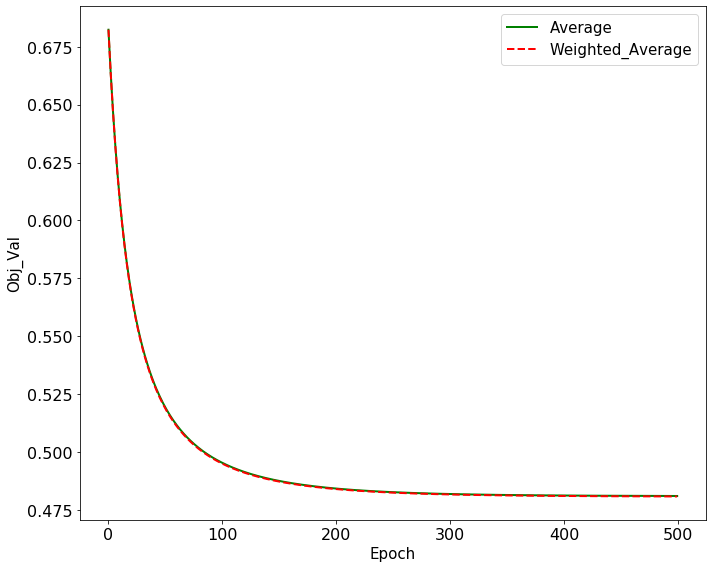

In [75]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))

epochs_val_avg = range(len(obj_val_avg))
epochs_weighted_avg = range(len(obj_val_weighted_avg))

line0, = plt.plot(epochs_val_avg, obj_val_avg, 'g', LineWidth=2)
line1, = plt.plot(epochs_weighted_avg, obj_val_weighted_avg, '--r', LineWidth=2)

plt.xlabel('Epoch', FontSize=15)
plt.ylabel('Obj_Val', FontSize=15)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['Average', 'Weighted_Average'], fontsize=15)


plt.tight_layout()
plt.show()